## Групповой проект по курсу Защита информации

# Реализация шифра Keccak

**Авторы:**  Кузнецов Алексей, Хромов Алексей, Серебряков Никита (715 группа)

**Задачи:**  Реализация шифра. Оценка скорости шифрования. Оценка лавинного эффекта. Оценка применимости атак.

**Содержание проекта:**

1. Описание алгоритма

2. Реализация алгоритма

3. Оценка скорости шифрования

4. Оценка лавинного эффекта

5. Оценка применимости атак

## Описание алгоритма

### Общие сведения

[$\text{Keccak}$](https://ru.wikipedia.org/wiki/SHA-3) $-$ это универсальная криптографическая функция. Более известный как хэш-функция, он, тем не менее, также может использоваться для аутентификации, (аутентифицированного) шифрования и генерации псевдослучайных чисел. Его структура представляет собой чрезвычайно простую конструкцию функции губки, и внутри он использует инновационную криптографическую перестановку $\text{Keccak-}f$.

Алгоритм был разработан [Guido Bertoni, Joan Daemen, Michaël Peeters и Gilles Van Assche](https://keccak.team/keccak.html) в 2008 году. В 2012 году $\text{Keccak}$ стал победителем [конкурса криптографических алгоритмов SHA-3](https://ru.wikipedia.org/wiki/SHA-3_(%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81)#%D0%9F%D0%BE%D0%B1%D0%B5%D0%B4%D0%B8%D1%82%D0%B5%D0%BB%D1%8C), проводимым Национальным институтом стандартов и технологий США (NIST, National Institute of Standards and Technology). После этого алгоритм был стандартизирован в [3GPP TS 35.231](https://keccak.team/specifications.html#3GPP_TS_35231) для мобильной телефонии (TUAK), а также был утвержден в качестве стандартов [FIPS 202](https://keccak.team/specifications.html#FIPS_202) и [SP 800-185](https://keccak.team/specifications.html#SP_800_185). Следовательно, он получил широкую общественную проверку и сторонний криптоанализ.

### Алгоритм

Хэш-функции семейства $\text{Keccak}$ построены на основе конструкции криптографической губки. В ней исходное сообщение $N$, дополненное определенным образом до нужной длины, сначала "впитывается" в губку, подвергаясь многораундовым перестановкам $f$, а затем результат $Z$ "отжимается" обратно из губки.

Семейство $\text{Keccak}$ параметризуется выбором скорости $r$ и емкостью $c$ так, что $r+c=b \in \{25, 50, 100, 200, 400, 800, 1600\}$. В нашем расмотрении ограничимся $b=1600$. Далее, последовательно рассмотрим шаги алгоритма.

Пусть у нас на входе имеется последовательность бит $N$, а длина выхода должна быть равна $d$. Тогда 

$$ \text{Keccak}[c](N, d) = \text{Sponge}[ \text{Keccak-}p[1600, n_r], \text{pad10*1}, 1600-c ] $$

Здесь $\text{Sponge}[f, \text{pad}, r]$ $-$ функция криптографической губки, в которой $f$ $-$ базовая функция перстановки, $\text{pad}$ $-$ правило дополнения, а $r$ $-$ скорость.

#### Функция $\text{Sponge}$

На вход функции $\text{Sponge}[f, \text{pad}, r](N, d)$ подается строка $N$ и неотрицательное число $d$. На выходе строка $Z$ длиной $\text{len}(Z) = d$. Алгоритм $\text{Sponge}$ содержит следующие шаги:

1. Строка $N$ доплняется до строки $P$ с помощью конкатенации и последовательности вида $1000...0001$: $$P = N || pad(r, len(N))$$

2. Вычисляется число раундов $n_r = \text{len}(P) / r$

3. Вычисляется емкость $c=b-r$

4. $P$ разбивается на последовательность строк $P_0, ..., P_{n-1}$, каждая длиной $r$, так, что $P = P_0 || ... || P_{n-1}$

5. Задается строка $S$ длиной $b$, состоящая из одних нулей: $S=0^b$

6. Для кахдого $i \in [0, n-1]$: $$S = f( S \oplus (P_i || 0^c) ),$$ где $\oplus$ $-$ ислючающее ИЛИ

7. Задается $Z$ как пустая строка

8. $Z$ конкатенируется с $\text{Trunc}_r(S)$: $$Z = Z || \text{Trunc}_r(S),$$ где $\text{Trunc}_r(S)$ возвращает строку, состоящую из битов от $S[0]$ до $S[r-1]$

9. Если $d \leq \text{len}(Z)$, то возвращается $\text{Trunc}_d(Z)$, иначе выполняется шаг 10

10. Вычисляется новое значение $S = f(S)$

#### Функция $\text{Keccak-}p[b, n_r](S)$

В описанном выше алгоритме для функции $\text{Sponge}$ используется функция перстановки $f$, она же $\text{Keccak-}p[b, n_r](S)$. Она принимает на вход строку $S$ длиной $b$ и число раундов $n_r$ и возвращает строку $S'$ длиной $b$, которая вычисляется следующим образом:

1. Строка $S$ преобразуется в массив состояния $\textbf{A}$$^*$

2. Для каждого $i_r$ от $12 + 2l - n_r$ до $12 + 2l - 1$ вычисляется новое значение $\textbf{A} = \text{Rnd}(\textbf{A}, i_r)$ (функция $\text{Rnd}(\textbf{A}, i_r)$ будет описана ниже)

3. Массив состояние $\textbf{A}$ преобразуется в строку $S'$ длины $b$

4. Функция возвращает строку $S'$

$^*$Описание структуры массива состояний $\textbf{A}$ будет обсуждаться ниже.

#### Функция $\text{Rnd}(\textbf{A}, i_r)$

Функция $\text{Rnd}(\textbf{A}, i_r)$ состоит из пяти шагов $(\theta, \rho, \pi, \chi, \iota)$ в следующем порядке:

$$ \text{Rnd}(\textbf{A}, i_r) = \iota( \chi( \pi( \rho( \theta(\textbf{A}) ) ) ), i_r ) $$

Она принимает на вход массив состояния $\textbf{A}$ и круговой индекс $i_r$ и возвращает измененный массив состояний.

##### **Шаг $\theta$**

Функция $\theta$ принимает на вход массив состояний $\textbf{A}$ и возвращает измененный массив состояний $\textbf{A'}$.

1. Для каждой пары $(x, z): 0 \leq x < 5, 0 \leq z < w$ строится двумерный массив:

$$ C[x, z] = \textbf{A}[x, 0, z] \oplus \textbf{A}[x, 1, z] \oplus \textbf{A}[x, 2, z] \oplus \textbf{A}[x, 3, z] \oplus \textbf{A}[x, 4, z] $$

2. Для каждой пары $(x, z): 0 \leq x < 5, 0 \leq z < w$ строится двумерный массив:

$$ D[x, z] = C[(x-1) \text{ mod } 5, z] \oplus C[(x+1) \text{ mod } 5, (z-1) \text{ mod } w] $$

3. Для каждой тройки $(x, y, z): 0 \leq x < 5, 0 \leq y < 5, 0 \leq z < w$ вычисляется новый массив состояний $\textbf{A'}$:

$$ \textbf{A'}[x, y, z] = \textbf{A}[x, y, z] \oplus D[x, z] $$

4. 4. Функция возвращает $\textbf{A'}$

##### **Шаг $\rho$**

Функция $\rho$ принимает на вход массив состояний $\textbf{A}$ и возвращает измененный массив состояний $\textbf{A'}$.

1. Определим для каждого $z : 0 \leq z < w$ $$\textbf{A'}[0, 0, z] = \textbf{A}[0, 0, z]$$

2. Пусть $(x, y) = (1, 0)$

3. Для $t$ от 0 до 23:
    
    3.1 $ \textbf{A'}[x, y, z] = \textbf{A}[x, y, (z - (t+1)(t-1) / 2) \text{ mod }w] $ для каждого $z : 0 \leq z < w$

    3.2 $(x, y) = (y, (2x + 3y) \text{ mod } 5)$

4. Функция возвращает $\textbf{A'}$

##### **Шаг $\pi$**

Функция $\pi$ принимает на вход массив состояний $\textbf{A}$ и возвращает измененный массив состояний $\textbf{A'}$.

1. Для каждой тройки $(x, y, z): 0 \leq x < 5, 0 \leq y < 5, 0 \leq z < w$ вычисляется новый массив состояний $\textbf{A'}$:

$$ \textbf{A'}[x, y, z] = \textbf{A}[(x + 3y) \text{ mod } 5, y, z] $$

2. Функция возвращает $\textbf{A'}$

##### **Шаг $\chi$**

Функция $\chi$ принимает на вход массив состояний $\textbf{A}$ и возвращает измененный массив состояний $\textbf{A'}$.

1. Для каждой тройки $(x, y, z): 0 \leq x < 5, 0 \leq y < 5, 0 \leq z < w$ вычисляется новый массив состояний $\textbf{A'}$:

$$ \textbf{A'}[x, y, z] = \textbf{A}[x, y, z] \oplus ( (\textbf{A}[(x + 1) \text{ mod } 5, y, z] \oplus 1) \cdot \textbf{A}[(x + 2) \text{ mod } 5, y, z]) $$

2. Функция возвращает $\textbf{A'}$

##### **Шаг $\iota$**

Функция $\iota$ принимает на вход массив состояний $\textbf{A}$ b круговой индекс $i_r$ и возвращает измененный массив состояний $\textbf{A'}$.

1. Для каждой тройки $(x, y, z): 0 \leq x < 5, 0 \leq y < 5, 0 \leq z < w$ определим $\textbf{A}[x, y, z] = \textbf{A'}[x, y, z]$

2. Определим $RC$ как строку длиной $w$, состоящую только из нулей: $$RC = 0^w$$

3. Для $j$ от нуля до $l$:

$$ RC[2^j - 1] = rc(j + 7i_r)^* $$

4. Определим для каждого $z : 0 \leq z < w$ $$\textbf{A'}[0, 0, z] = \textbf{A}[0, 0, z] \oplus RC[z]$$

5. Функция возвращает $\textbf{A'}$

$^*$Мы опустим описание функции $rc(t)$, но отметим, что она возвращает только один бит.

#### Структура массива состояния $\textbf{A}$

Массив состояния $\textbf{A}$ $-$ это трехмерный массив, получающийся из строки $S$ следующим образом: $$\textbf{A}[x, y, z] = S[w(5y + x) + z],$$ где $0 \leq x < 5, 0 \leq y < 5, 0 \leq z < w$. Поскольку в ланной работе мы рассматриваем только вариант реализации с $S$ длиной $b=1600$, то $w=64$. Геометрическая интепритация массива $\textbf{A}$ с названиями всех структур в нем представлена на рисунке ниже:

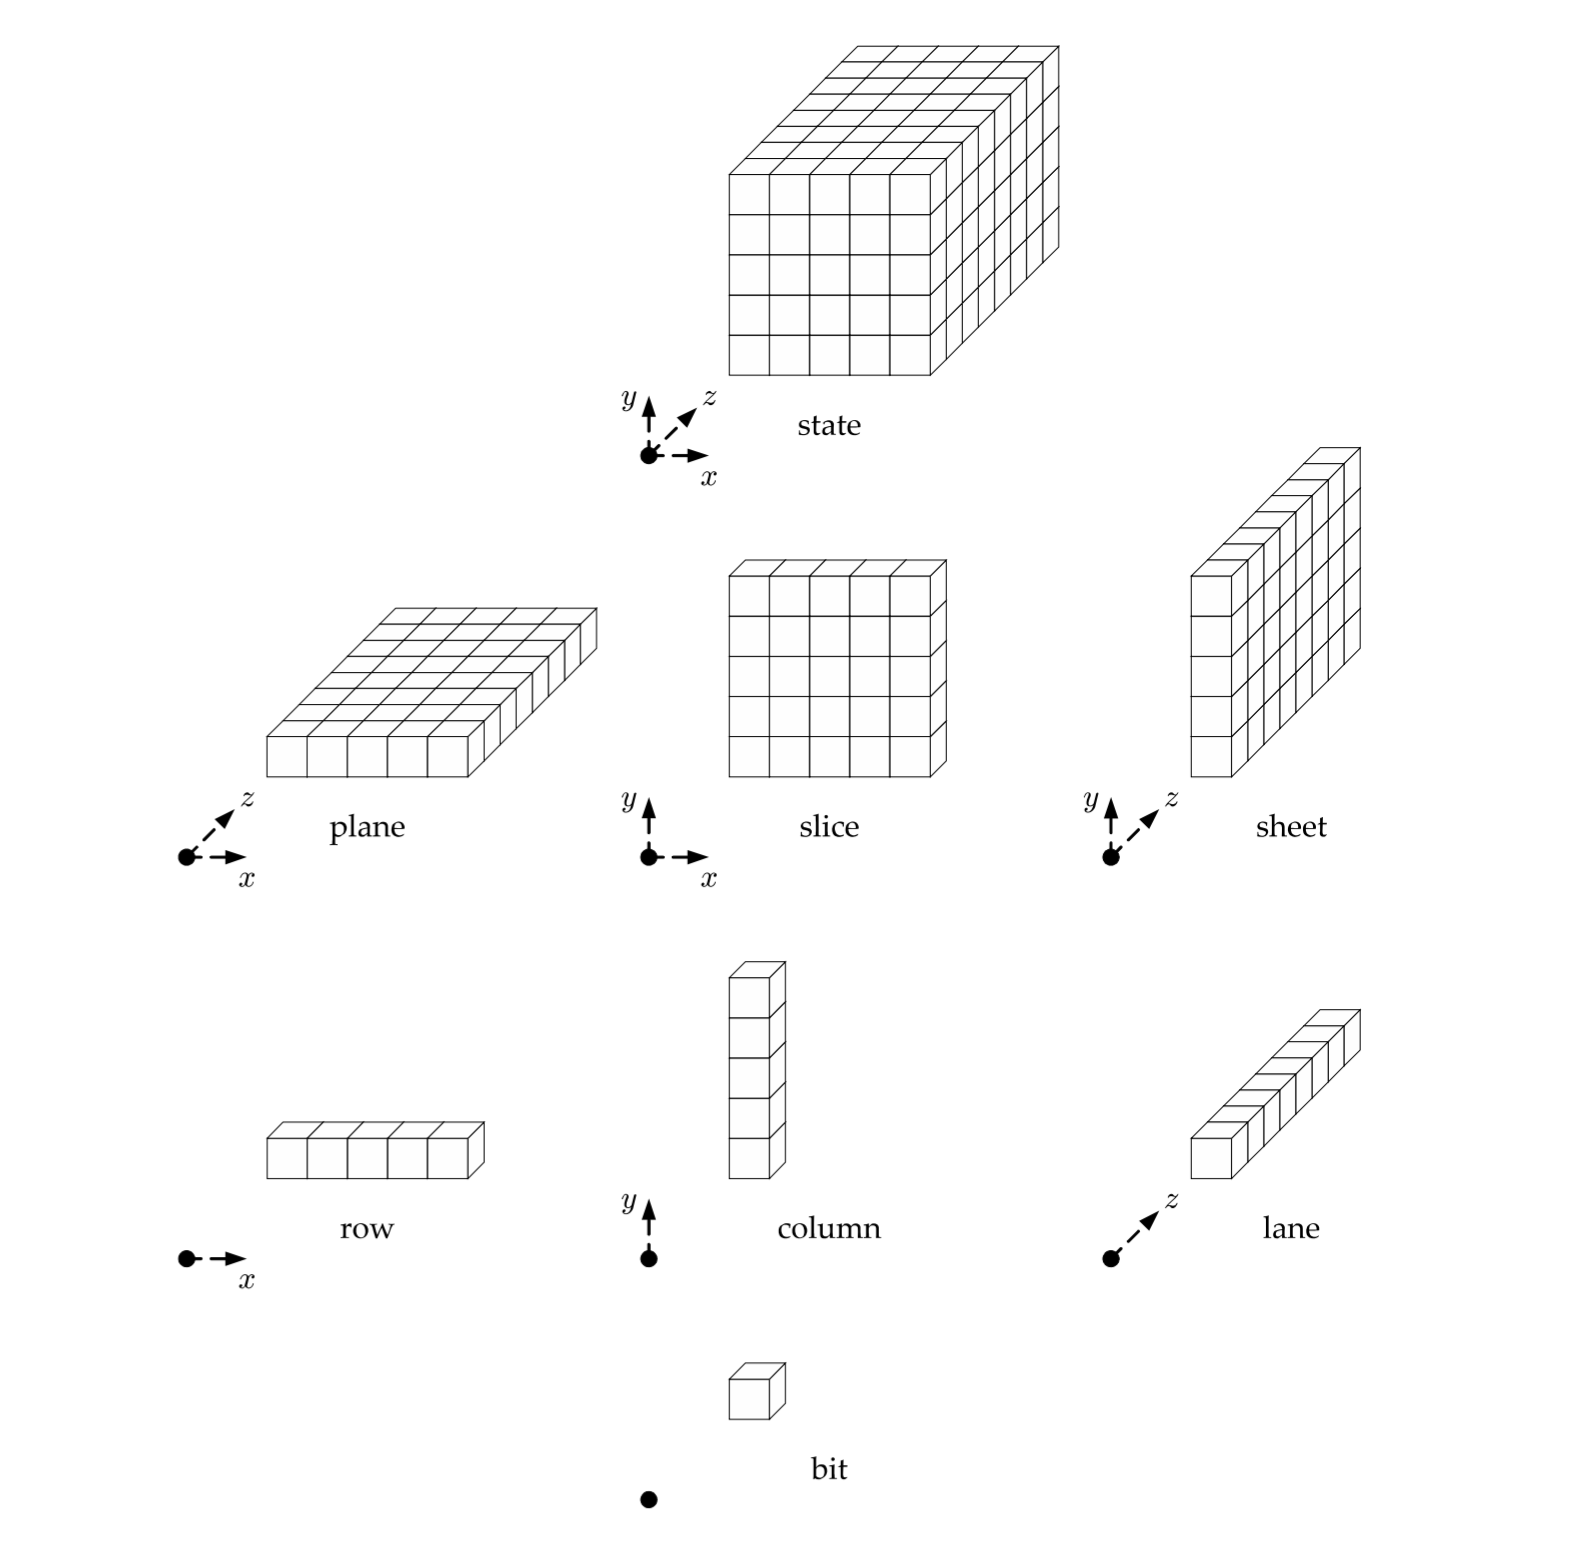

#### Функция дополнения $\text{pad}$

В качестве правила заполнения в алгоритме $Keccak$ используется функция $\text{pad10*1}$, которая принимает на вход положительное число $x$ и неотрицательное число $m$ и возвращает строку $P$. Вычисление значения функции состоит из следующих шагов:

1. Вычисляется $j = (- m - 2) \text{ mod } x$

2. Функция возвращает $P = 1 || 0^j || 1$

## Реализация алгоритма

In [ ]:
def ROL64(a, n):
    return ((a >> (64-(n%64))) + (a << (n%64))) % (1 << 64)

def Keccak_f1600_on_lanes(lanes):
    R = 1
    for round in range(24):
        # шаг "тэта"
        C = [lanes[x][0] ^ lanes[x][1] ^ lanes[x][2] ^ lanes[x][3] ^ lanes[x][4] for x in range(5)]
        D = [C[(x+4)%5] ^ ROL64(C[(x+1)%5], 1) for x in range(5)]
        lanes = [[lanes[x][y]^D[x] for y in range(5)] for x in range(5)]

        # шаги "ро" и "пи"
        (x, y) = (1, 0)
        current = lanes[x][y]
        for t in range(24):
            (x, y) = (y, (2*x+3*y)%5)
            (current, lanes[x][y]) = (lanes[x][y], ROL64(current, (t+1)*(t+2)//2))

        # шаг "хи"
        for y in range(5):
            T = [lanes[x][y] for x in range(5)]
            for x in range(5):
                lanes[x][y] = T[x] ^((~T[(x+1)%5]) & T[(x+2)%5])

        # шаг "йота"
        for j in range(7):
            R = ((R << 1) ^ ((R >> 7)*0x71)) % 256
            if (R & 2):
                lanes[0][0] = lanes[0][0] ^ (1 << ((1<<j)-1))

    return lanes

def load64(b):
    return sum((b[i] << (8*i)) for i in range(8))

def store64(a):
    return list((a >> (8*i)) % 256 for i in range(8))

def Keccak_f1600(state):
    lanes = [[load64(state[8*(x+5*y):8*(x+5*y)+8]) for y in range(5)] for x in range(5)]
    lanes = Keccak_f1600_on_lanes(lanes)
    state = bytearray(200)
    for x in range(5):
        for y in range(5):
            state[8*(x+5*y):8*(x+5*y)+8] = store64(lanes[x][y])
    return state

def Keccak(rate, capacity, input_bytes, delimited_suffix, n_output_bytes):
    output_bytes = bytearray()
    state = bytearray([0 for i in range(200)])
    rate_in_bytes = rate//8
    block_size = 0
    if (((rate + capacity) != 1600) or ((rate % 8) != 0)):
        return
    shift = 0

    # ----- "Впитывание" всех входных блоков -----
    while(shift < len(input_bytes)):
        block_size = min(len(input_bytes)-shift, rate_in_bytes)

        for i in range(block_size):
            state[i] = state[i] ^ input_bytes[i+shift]

        shift = shift + block_size
        if (block_size == rate_in_bytes):
            state = Keccak_f1600(state)
            block_size = 0

    # ----- Доплолнение и переход к "отжиманию" -----
    state[block_size] = state[block_size] ^ delimited_suffix
    if (((delimited_suffix & 0x80) != 0) and (block_size == (rate_in_bytes-1))):
        state = Keccak_f1600(state)

    state[rate_in_bytes-1] = state[rate_in_bytes-1] ^ 0x80
    state = Keccak_f1600(state)

    # ----- "Отжимание" всех выходных блоков -----
    while(n_output_bytes > 0):
        block_size = min(n_output_bytes, rate_in_bytes)
        output_bytes = output_bytes + state[0:block_size]
        n_output_bytes = n_output_bytes - block_size
        if (n_output_bytes > 0):
            state = Keccak_f1600(state)

    return output_bytes

def SHAKE128(input_bytes, n_output_bytes):
    return Keccak(1344, 256, input_bytes, 0x1F, n_output_bytes)

def SHAKE256(input_bytes, n_output_bytes):
    return Keccak(1088, 512, input_bytes, 0x1F, n_output_bytes)

def SHA3_224(input_bytes):
    return Keccak(1152, 448, input_bytes, 0x06, 224//8)

def SHA3_256(input_bytes):
    return Keccak(1088, 512, input_bytes, 0x06, 256//8)

def SHA3_384(input_bytes):
    return Keccak(832, 768, input_bytes, 0x06, 384//8)

def SHA3_512(input_bytes):
    return Keccak(576, 1024, input_bytes, 0x06, 512//8)

## Оценка скорости шифрования

Для оценки скорости шифрования и получения наглядного результата запустим функцию `Keccak` 10000 раз для значений скорости $(rate)$ от $128$ до $1536$ и усредним время каждого выполнения функции. В свою очередь, значение емкости будет всегда равно $1600-rate$. В качестве входных данных будет пустая строка. Эксперимент будем проводить для значений длины выходной строки $\{1, 2, 4, 8, 16, 32\}$. Для получившихся значений построим гравик усредненного времени выполнения функции от скорости $rate$.

In [ ]:
import matplotlib.pyplot as plt
import time

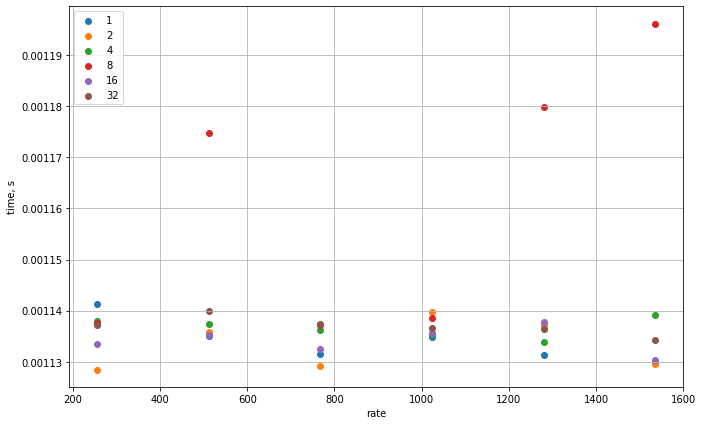

In [ ]:
n_output_bytes = [1, 2, 4, 8, 16, 32]
t = [[] for k in range(len(n_output_bytes))]
r = [(i+1) * 256 for i in range(6)]

for k in range(len(n_output_bytes)):
    for i in range(6):
        start = time.time()
        for _ in range(10000):
            output = Keccak(r[i], 1600-r[i], bytearray("", "utf-8"), 0x06, n_output_bytes[k])
        t[k].append((time.time() - start) / 10000)

fig = plt.figure(figsize=(11, 7))
for T in t:
    plt.scatter(r, T)

plt.xlabel("rate")
plt.ylabel("time, s")
plt.legend(n_output_bytes)
plt.grid(True)
plt.show()

Основываясь на данных графика выше, можно сделать следующие выводы. Во-первых, время шифрования при длине выходной строки в $1$ байт нестабильно относительно скорости $rate$ и худший результат показан именно на этой длине при `rate=1024`. Во-вторых, при том же значении `rate=1024` для остальных длин выходной строки показан лучший результат и, в целом, в этом месте на графике виден явный оптимум. Поэтому можно утверждать, что оптимальным вариантом $\text{Keccak}$ будет алгоритм с параметрами `rate=1024, capacity=576`.

## Оценка лавинного эффекта

**Лавинный эффект** (англ. *Avalanche effect*) — важное криптографическое свойство для шифрования, которое означает, что изменение значения малого количества битов во входном тексте или в ключе ведет к "лавинному" изменению значений выходных битов шифротекста. Другими словами, это зависимость всех выходных битов от каждого входного бита. Если криптографический алгоритм не обладает лавинным эффектом в достаточной степени, криптоаналитик может сделать предположение о входной информации, основываясь на выходной информации. Таким образом, достижение лавинного эффекта является важной целью при разработке криптографического алгоритма.

**Коэффициент лавинного эффекта** $-$ это вероятность изменения каждого выходного бита при изменении одного входного бита, т.е.

$$ \text{Коэффициент лавинного эффекта} = \frac{ \text{ Число изменившихся битов выходной строки } }{ \text{ Число всех битов выходной строки } } $$

Очевидно, что в идеальном случае эта вероятность должна составлять $0,5$, что значит, что каждый бит выходной строки изменится с вероятностью $0,5$ при изменении одного бита на входе функции.

Следующий эксперимент будет заключаться в подсчете коэффициента лавинного эффекта. Для того, чтобы посчитать коэффициент лавинного эффекта, запустим следующий алгоритм. на каждом шаге для какой-то входной строки вычисляем `ref = Keccak(1088, 512, input, 0x06, 8)`, где число байт выхода функции равно 8. Затем с помощью $\text{xor}$ изменяем по одному биту в `ref` и снова вычисляем `Keccak(1088, 512, changed_input, 0x06, 8)`. Для двух выходов считаем количество одинаковых бит и делим на полное количество бит на выходе.

In [ ]:
def similarity(x, y):
    xor = ~(~x ^ y)
    l = max(len(bin(x)), len(bin(y)))
    
    return bin(2 ** (l - 2) - 1 - xor).count("1")

In [ ]:
###### ВНИМАНИЕ!  CAUTION!  ACHTUNG!  ¡ATENCIÓN! ######
##                                                   ##
##  ЗАПУСКАТЬ ТОЛЬКО В СЛУЧАЕ КРАЙНЕЙ НЕОБХОДИМОСТИ  ##
##             ВЫПОЛНЯЕТСЯ ОЧЕНЬ ДОЛГО               ##
##                                                   ##
#######################################################


AEC = []
for x in range(50000):
    input = bytearray(str(hex(x)), 'utf-8')
    ref = Keccak(1088, 512, input, 0x06, 8)
    l = len(ref.hex())
    ref = int.from_bytes(ref, byteorder='big')

    for i in range(l):
        changed_input = ~(~int.from_bytes(input, byteorder='big') ^ 2**i)
        changed_input = changed_input.to_bytes(10, byteorder='big')
        output = Keccak(1088, 512, changed_input, 0x06, 8)
        output = int.from_bytes(output, byteorder='big')
        AEC.append(similarity(ref, output) / 64)

# print(np.unique(np.array(AEC), return_counts=True))

Выведем все получившиеся коэффициенты и их частоту, чтобы посмотреть какое значение встречается чаще всего.

In [ ]:
coefs, counts = np.unique(np.array(AEC), return_counts=True)
for i in range(len(coefs)):
    print("{:.6f} - {}".format(coefs[i], counts[i]))

0.234375 - 5
0.250000 - 7
0.265625 - 12
0.281250 - 48
0.296875 - 87
0.312500 - 240
0.328125 - 432
0.343750 - 863
0.359375 - 1528
0.375000 - 2541
0.390625 - 4101
0.406250 - 5840
0.421875 - 8238
0.437500 - 10341
0.453125 - 12751
0.468750 - 14533
0.484375 - 15672
0.500000 - 15887
0.515625 - 15060
0.531250 - 13463
0.546875 - 11356
0.562500 - 8893
0.578125 - 6520
0.593750 - 4629
0.609375 - 2961
0.625000 - 1906
0.640625 - 1085
0.656250 - 543
0.671875 - 262
0.687500 - 116
0.703125 - 58
0.718750 - 11
0.734375 - 8
0.750000 - 2
0.765625 - 1


Чаще всего встречается коэффициент $0,5$, а значит можно утверждать, что данный алгоритм **удовлетворяет строгому лавинному критерию и является надежным**. Чтобы в этом убедиться, построим гистограмму.

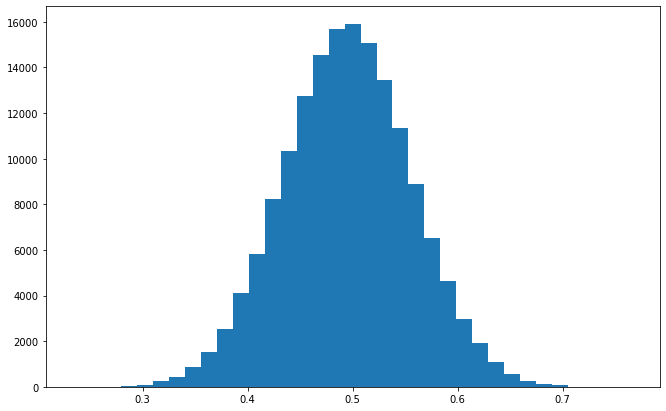

In [ ]:
fig = plt.figure(figsize=(11, 7))
hist = plt.hist(AEC, bins=len(np.unique(np.array(AEC))))
plt.show()

## Оценка безопасности алгоритма $\text{Keccak}$

2 октября 2012 года алгоритм $\text{Keccak}$ стал победителем конкурса SHA-3, проводимого с 2007 года. Целью конкурса было создание нового криптографического алгоритма для замены хэш-функции SHA-2. Считалось, что надежность последней значительно снизится из-за роста мощности и производительности, а также появления новых методов криптоанализа. Алгоритм $\text{Keccak}$ стал самым производительным на аппаратной реализации среди финалистов конкурса, также его существенным преимуществом стала возможность его реализации на миниатюрных устройствах (например, USB-флэш-накопитель).

Поскольку реализация атаки такой надежный алгоритм очень сложна, мы ограничимся только описанием имеющихся данных.

### Предфинальный отчет конкурса SHA-3

Предфинальный [отчет](https://nvlpubs.nist.gov/nistpubs/ir/2012/NIST.IR.7896.pdf) конкурса содержит информацию о различных атаках на алгоритм $\text{Keccak}$. Почти все они были проделаны над урезанными версиями алгоритма, в основном, с меньшим количеством раундов перестановок.

[Bertoni et al.](http://rd.springer.com/chapter/10.1007/978-3-540-78967-3_11) доказал, что $\text{Keccak-}n$ защищен от атак с нахождением прообраза, вторым прообраза и коллизий до $2^n$, $2^n$ и $2^{n/2}$ запросов соответсвенно, если базовая перестановка идеальна. Также Bertoni et al. доказал, что при том же предположении, $\text{Keccak-}n$ неотличим от генератора случайных чисел до $2^n$ запросов, что означает, что $\text{Keccak-}n$ защищен от всех общих нетривиальных атак до $2^n$ запросов.

[Gligoroski et al.](http://eprint.iacr.org/2011/261) заметил, что если обнаружен конкретный второй прообраз (что, скорее всего, требует одноразового усилия, эквивалентного brute-force), то для любого сообщения можно очень легко найти произвольное количество вторых прообразов.

[Aumasson и Khovratovich](http://www.131002.net/data/papers/AK09.pdf) предприняли попытку алгебраических атак против версий $\text{Keccak}$ с значительно сокращенным циклом, применив инструменты автоматического криптоанализа (инструмент триангуляции и тестеры кубов) к перестановке $\text{Keccak}$. Анализ был ограничен трех- и четырехраундными версиями $\text{Keccak}$, но авторы предположили, что структуры могут наблюдаться при перестановке до десяти раундов. Авторы пришли к выводу, что $\text{Keccak}$ имеет удобный запас прочности для предотвращения структурных различий.

[Morawiecki и Srebrny](http://eprint.iacr.org/2010/285.pdf) использовали методы SAT-решателя, чтобы найти прообразы для трех раундов $\text{Keccak}$ с 40 неизвестными битами сообщения.

[Aumasson и Meier](http://www.131002.net/data/papers/AM09.pdf) впервые показали на практике отличители с нулевой суммой на девяти этапах перестановки $\text{Keccak}$ и непрактичные отличительные признаки на шестнадцати этапах. [Boura и Canteaut](http://www-rocq.inria.fr/secret/Anne.Canteaut/Publications/zero_sum.pdf) позже расширили это число до восемнадцати раундов. Однако при сложности $2^{1370}$ эта атака представляет только теоретический интерес. Команда $\text{Keccak}$ увеличила количество раундов до двадцати четырех после объявления первоначального отличителя. После этого продолжали публиковаться отличительные признаки очень высокой сложности: [Boura и Canteaut](https://www.rocq.inria.fr/secret/Christina.Boura/data/sac.pdf) атаковали 20 раундов со сложностью 21586. [Boura et al.](http://fse2011.mat.dtu.dk/slides/Higher-order%20differential%20properties%20of%20Keccak%20and%20Luffa.pdf) атаковали все 24 раунда со сложностью $2^{1590}$.

[Lathrop](https://ritdml.rit.edu/bitstream/handle/1850/10821/20782_pdf_C9905D10-60E8-11DE-AE1A-0950D352ABB1.pdf?sequence=1) смог использовать атаку куба для проведения атаки с восстановлением ключа на секретный префиксный код аутентификации сообщения (MAC) с четырехэтапным вариантом $\text{Keccak}$.

Все полученные данные подытожены в таблице.


> | Цель | Тип атаки | Выход | Вариант | Количество вызовов |
> | --- | --- | --- | --- | --- |
> | Перестановки | Наблюдатели | все  |            |               |
> | Хэш-функция  | Прообраз    | 1024 | 3 раунда   | $2^{34}$      |
> | Перестановки | Отличитель  | все  | 9 раундов  | $2^{29.83}$   |
> | Перестановки | Отличитель  | все  | 14 раундов | $2^{255.77}$  |
> | Перестановки | Отличитель  | все  | 16 раундов | $2^{1023.88}$ |
> | Перестановки | Отличитель  | все  | 18 раундов | $2^{1370}$    |
> | Перестановки | Отличитель  | все  | 20 раундов | $2^{1586}$    |
> | Перестановки | Отличитель  | все  | 24 раунда  | $2^{1590}$    |
> | Секретный префикс MAC | Восстановление ключа | 224 | 4 раунда | $2^{19}$ |





### Финальный отчет конкурса SHA-3

Аналогично предфинальному отчету составлен финальный отчет.

[Morawiecki](http://keccak.noekeon.org/crunchy_contest.html) использовал методы SAT-решателя для поиска прообразов для двух раундов $\text{Keccak}$ с 80 неизвестными битами сообщения и для обнаружения коллизий на двух раундах $\text{Keccak}$ с 160-битным выходом. Обе версии были конкурсными, с уменьшенной до 160 бит емкостью. Morawiecki продемонстрировал низкую сложность атаки, фактически выполнив атаку, а не вычислив теоретическую сложность.

[Duan и Lai](http://eprint.iacr.org/2011/023.pdf) улучшили временную сложность 24-раундового распознавания с нулевой суммой до $2^{1579}$.

[Duc et al.](http://eprint.iacr.org/2011/420.pdf) применили методы отскока, чтобы найти дифференциальное свойство отскока для восьми раундов перестановки Кеккака с временной сложностью $2^{491,47}$.

Bernstein использовал алгебраические методы, чтобы ускорить перебор второго прообраза методом перебора до восьми раундов Keccak.

[Naya-Plasencia et al.](http://naya.plasencia.free.fr/Maria/papers/Keccak_differential.pdf) представили атаку-прообраз на двух раундах $\text{Keccak-}224$ и $\text{Keccak-}256$, атаку со столкновением с двумя раундами и атаку с близким столкновением к трем раундам $\text{Keccak-}224$ и $\text{Keccak-}256$.

[Dinur et al.](http://eprint.iacr.org/2011/624.pdf) привели примеры столкновений для $\text{Keccak-}224$ и $\text{Keccak-}256$, уменьшенных до четырех раундов, и близких столкновений на пяти раундах.

> | Цель | Тип атаки | Выход | Вариант | Количество вызовов | Память |
> | --- | --- | --- | --- | --- | --- |
> | Хэш-функция | Коллизии | 160  | r={240, 640, 1440}; c=160; 1,2 раунда | | |
> | Хэш-функция | Прообраз | 80 | r={240, 640, 1440}; c=160; 1,2 раунда | | |
> | Перестановки | Отличитель | все | 24 раунда | $2^{1579}$ | |
> | Перестановки | Дифференциальное свойство | все | 8 раундов | $2^{491.47}$ | |
> | Хэш-функция | Отличитель | 224, 256 | 4 раунда | $2^{25}$ | |
> | Хэш-функция | Ближайшая коллизия | 224, 256 | 3 раунда | $2^{25}$ | |
> | Хэш-функция | Коллизия | 224, 256 | 2 раунда | $2^{33}$ | |
> | Хэш-функция | Второй прообраз | 224, 256 | 2 раунда | $2^{33}$ | $2^{29}$ |
> | Хэш-функция | Второй прообраз | 512 | 6 раундов | $2^{506}$ | $2^{176}$ |
> | Хэш-функция | Второй прообраз | 512 | 7 раундов | $2^{507}$ | $2^{320}$ |
> | Хэш-функция | Второй прообраз | 512 | 8 раундов | $2^{511.5}$ | $2^{508}$ |
> | Хэш-функция | Коллизия | 224, 256 | 4 раунда |  |  |
> | Хэш-функция | Ближайшая коллизия | 224, 256 | 5 раундов |  |  |